# Data Sources & Info

September 18, 2021

Data collected via https://ucannualwage.ucop.edu/, via the command line:

```sh
curl 'https://ucannualwage.ucop.edu/wage/search.action?_search=false&nd=1631391241333&rows=600000&page=1&sidx=EAW_LST_NAM&sord=asc&year=2010&location=ALL&firstname=&lastname=&title=&startSal=&endSal=' -o all-records-2010.json
```

for each year 2010 through 2020.

## Pay Descriptions:


* Gross Pay -- base salary + additional funding (grants, etc)
* Regular Pay -- base salary

**In "Regular Pay" mode rows with Regular Pay == 0 are filtered.**


In [ ]:
USE_GROSS_PAY = False

In [ ]:
import pandas as pd
import numpy as np
import json
import re
import seaborn as sns
import sys
from functools import reduce

# import pandas_profiling as pp

np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(formatter={'int_kind': '{:,}'.format})
pd.options.display.float_format = '{:,}'.format

In [ ]:
TITLE_CODE_TYPE_SHEET = 'https://docs.google.com/spreadsheets/u/1/d/19MG1bKoQh6o6PAAYHAmdFyNpNspQ3tfQ6jpMbou_rw8/gviz/tq?tqx=out:csv&sheet=All%20UC%20Title%20Codes'

TITLE_CODE_MAP = pd.read_csv(TITLE_CODE_TYPE_SHEET)
print(TITLE_CODE_MAP['Category'].unique())

['Unit 18' 'Non-Senate' 'Teaching Track' 'Students' 'Student Reasearch'
 'Student Instruction' 'Staff' 'Senate' 'Research Staff' 'Research'
 'Med Center' 'Coach' 'Athletics' 'Admin Staff' 'Admin' 'Acad Staff' nan]


In [ ]:
# Files
START_YEAR = 2010
END_YEAR = 2020
GROSS_PAY = 'Gross Pay'
REG_PAY = 'Regular Pay'

PAY_COL = GROSS_PAY if USE_GROSS_PAY else REG_PAY

# id is just the row number PER YEAR, but not super meaningful.
# it is included in the JSON data.
COLUMNS = ['id', 'Year', 'Location', 'First Name', 'Last Name', 'Title', 'Gross Pay', 'Regular Pay', 'Overtime Pay', 'Other Pay']
# LECT_PREFIX = 'LECT-' # Caputes 'LECT-AY', excludes LECT PSOE / LECT SOE

def safe_parse(value):
    try:
        return float(value)
    except:
        return value

DATA_LOADED = {}
def load_data_for_year(year):
    raw_data = open(f"json/all-records-{year}.json").read()
    raw_data = raw_data.replace("'", '"')
    raw_data = re.sub(r'[\x00-\x1f\x7f-\x9f]', '', raw_data)
    parsed = json.loads(raw_data)
    data = [ [ safe_parse(value) for value in row['cell'] ] for row in parsed['rows'] ]

    df = pd.DataFrame(data, columns= COLUMNS)
    if not USE_GROSS_PAY:
        df = df.loc[ df[PAY_COL] > 0]
    return df

# Titles (Roughly) Grouped By Function / School

In [ ]:
def filter_by_school(df, location):
    return df.loc[ df['Location'] == location ]

valid_categories = TITLE_CODE_MAP['Category'].unique()
def titles_in_category(df, category):
    if not category or category == 'All':
        return df # just don't filter.
    if type(category) != list:
        category = [category]
    for c in category:
        assert c in valid_categories,  f'"{c}" is not a valid title code category'
    titles = TITLE_CODE_MAP[TITLE_CODE_MAP['Category'].isin(category)]['Title']
    return df.loc[ df['Title'].isin(titles) ]

In [ ]:
TITLE_CODE_MAP[TITLE_CODE_MAP['Category'] == 'Unit 18']['Title']

0         CONTINUING APPT-TEMP AUG
1     CONTINUING APPT-TEMP AUG-1/9
2       COORD FLD WK-AY-CONTINUING
3                  COORD FLD WK-FY
4       COORD FLD WK-FY-CONTINUING
5                FLD WK CONSULT-AY
6     FLD WK CONSULT-AY-CONTINUING
7                   FLD WK SUPV-AY
8                   FLD WK SUPV-FY
9           LECT IN SUMMER SESSION
10                         LECT-AY
11                    LECT-AY-1/10
12         LECT-AY-1/10-CONTINUING
13                     LECT-AY-1/9
14          LECT-AY-1/9-CONTINUING
15              LECT-AY-CONTINUING
16                         LECT-FY
17              LECT-FY-CONTINUING
19                        LECTURER
20                      SR LECT-AY
21       SR LECT-AY-1/9-CONTINUING
22           SR LECT-AY-CONTINUING
23               TEACHER-SPEC PROG
24    TEACHER-SPEC PROG-CONTINUING
Name: Title, dtype: object

# Load DataFrames

In [ ]:
salaries_2020 = load_data_for_year('2020')

lect_salaries_2020 = titles_in_category(salaries_2020, 'Unit 18') 
all_berkeley_salaries = filter_by_school(salaries_2020, 'Berkeley')
berkeley_lect_salaries_2020 = filter_by_school(lect_salaries_2020, "Berkeley")


In [ ]:
berk_titles = all_berkeley_salaries['Title'].unique()
print(berk_titles.size)
# print(np.sort(berk_titles))

965


In [ ]:
lpsoe_all_uc = titles_in_category(salaries_2020, 'Teaching Track')
senate_all_uc = titles_in_category(salaries_2020, 'Senate')
non_senate_all_uc = titles_in_category(salaries_2020, 'Non-Senate')
# print(lpsoe_all_uc.count())

role_counts = [
    lpsoe_all_uc.groupby('Location')['Location'].count().reset_index(name='Count LSOE'),
    lect_salaries_2020.groupby('Location')['Location'].count().reset_index(name='Count Unit 18'),
    senate_all_uc.groupby('Location')['Location'].count().reset_index(name='Count Senate Faculty'),
    non_senate_all_uc.groupby('Location')['Location'].count().reset_index(name='Count Non-Senate Faculty'),
]

reduce(lambda x, y: x.merge(y, on='Location', how='outer'), role_counts)



,Location,Count LSOE,Count Unit 18,Count Senate Faculty,Count Non-Senate Faculty
0,Berkeley,26.0,1433,1615,301.0
1,Davis,45.0,597,2076,682.0
2,Irvine,99.0,603,1531,689.0
3,Los Angeles,13.0,1359,2478,"2,188.0"
4,Merced,24.0,181,296,NaN
5,Riverside,38.0,317,869,131.0
6,San Diego,101.0,488,1872,"1,273.0"
7,Santa Barbara,58.0,369,948,57.0
8,Santa Cruz,23.0,367,589,36.0
9,Hastings,NaN,17,55,120.0


In [ ]:
lect_role_counts = [
    berkeley_lect_salaries_2020.groupby('Title')['Regular Pay'].describe(),
    berkeley_lect_salaries_2020.groupby('Title')['Gross Pay'].describe() #.reset_index(name='Gross Pay'),
]

def rename_xy(name):
    return name.replace('_x', ' Regular Pay').replace('_y', ' Gross Pay')

lect_gross_regular = reduce(lambda x, y: x.merge(y, on='Title', how='outer'), lect_role_counts)

# cols = [ lect_gross_regular.columns[0] ] + sorted(lect_gross_regular.columns[1:])
# print(cols)
# ['count_x', '25%_x', '25%_y', '50%_x', '50%_y', '75%_x', '75%_y', 'count_y', 'max_x', 'max_y', 'mean_x', 'mean_y', 'min_x', 'min_y', 'std_x', 'std_y']
cols = ['count_x', '25%_x', '25%_y', '50%_x', '50%_y', 'mean_x', 'mean_y', 'min_x', 'min_y', 'std_x', 'std_y']

lect_gross_regular[cols].rename(columns=rename_xy)

,count Regular Pay,25% Regular Pay,25% Gross Pay,50% Regular Pay,50% Gross Pay,mean Regular Pay,mean Gross Pay,min Regular Pay,min Gross Pay,std Regular Pay,std Gross Pay
Title,,,,,,,,,,,
CONTINUING APPT-TEMP AUG,4.0,"47,833.25","47,833.25","62,580.0","62,580.0","64,723.0","76,528.25","33,074.0","33,074.0","28,840.412514386822","50,204.41077153148"
COORD FLD WK-AY-CONTINUING,1.0,"134,393.0","157,374.0","134,393.0","157,374.0","134,393.0","157,374.0","134,393.0","157,374.0",NaN,NaN
COORD FLD WK-FY-CONTINUING,1.0,"154,088.0","154,088.0","154,088.0","154,088.0","154,088.0","154,088.0","154,088.0","154,088.0",NaN,NaN
FLD WK CONSULT-AY,7.0,"22,117.0","22,117.0","37,868.0","37,868.0","45,595.57142857143","50,422.71428571428","7,037.0","7,037.0","35,327.61633555795","43,111.90065675712"
FLD WK CONSULT-AY-CONTINUING,4.0,"92,700.75","106,782.25","102,080.0","117,022.0","95,489.0","112,782.0","71,739.0","86,218.0","16,063.115243729448","19,074.842087594505"
FLD WK SUPV-AY,1.0,"4,792.0","4,792.0","4,792.0","4,792.0","4,792.0","4,792.0","4,792.0","4,792.0",NaN,NaN
FLD WK SUPV-FY,18.0,"24,383.75","24,744.5","34,465.5","34,465.5","48,870.166666666664","50,687.166666666664","3,289.0","3,289.0","37,060.73963302755","38,373.82749961995"
LECT IN SUMMER SESSION,47.0,"8,831.5","15,472.0","12,404.0","19,903.0","18,302.76595744681","26,644.957446808512","1,128.0","2,285.0","15,722.225210652214","18,471.863414343174"
LECT-AY,319.0,"10,495.0","10,830.5","27,477.0","30,204.0","33,690.53605015674","37,915.416927899685",47.0,47.0,"28,266.168400104518","32,941.21504651458"


In [ ]:
non_senate_counts['Location'].unique()

# .groupby('Title')['Title'].count().reset_index(name='count').sort_values(['count'])


NameError: name 'non_senate_counts' is not defined

In [ ]:
lpsoe_all_uc['Gross Pay'].describe()

count                 427.0
mean    133,328.38641686182
std     51,626.422594984884
min                 7,308.0
25%               104,400.0
50%               125,461.0
75%               156,793.0
max               370,311.0
Name: Gross Pay, dtype: float64

In [ ]:
filter_by_school(lpsoe_all_uc, 'Berkeley').groupby('Title')['Regular Pay'].describe()

,count,mean,std,min,25%,50%,75%,max
Title,,,,,,,,
ACT LECT PSOE-AY-B/E/E,1.0,"46,250.0",NaN,"46,250.0","46,250.0","46,250.0","46,250.0","46,250.0"
LECT PSOE-AY,2.0,"91,046.0","2,327.7955236661146","89,400.0","90,223.0","91,046.0","91,869.0","92,692.0"
LECT PSOE-AY-B/E/E,1.0,"117,225.0",NaN,"117,225.0","117,225.0","117,225.0","117,225.0","117,225.0"
LECT SOE-AY,6.0,"107,358.33333333333","33,655.52579691285","50,000.0","100,712.5","110,900.0","120,225.0","151,700.0"
LECT SOE-AY-B/E/E,3.0,"137,525.0","2,950.31777949427","134,600.0","136,037.5","137,475.0","138,987.5","140,500.0"
SR LECT SOE-AY,6.0,"150,811.0","12,051.569441363228","132,000.0","145,904.0","152,000.0","156,045.5","167,600.0"
SR LECT SOE-AY-B/E/E,4.0,"156,685.5","15,907.752020110614","141,700.0","145,825.0","153,800.0","164,660.5","177,442.0"
SR LECT SOE-AY-LAW,3.0,"281,555.3333333333","14,072.469446878658","270,300.0","273,666.5","277,033.0","287,183.0","297,333.0"


In [ ]:
# all_berkeley_salaries.groupby('Title')['Title'].count().reset_index(name='count').sort_values(['count'])

In [ ]:
lect_salaries_2020.groupby('Title')['Title'].count().reset_index(name='count').sort_values(['count']) # .to_csv('titles_and_counts.csv')

,Title,count
2,COORD FLD WK-AY-CONTINUING,1
3,COORD FLD WK-FY,1
7,FLD WK SUPV-AY,1
19,SR LECT-AY,1
4,COORD FLD WK-FY-CONTINUING,2
20,SR LECT-AY-1/9-CONTINUING,2
6,FLD WK CONSULT-AY-CONTINUING,5
1,CONTINUING APPT-TEMP AUG-1/9,7
5,FLD WK CONSULT-AY,10
18,LECTURER,17


In [ ]:
lect_salaries_2020['Gross Pay'].describe()

count      4467.000000
mean      41921.472353
std       42457.076175
min           8.000000
25%        7641.000000
50%       28191.000000
75%       66645.500000
max      476036.000000
Name: Gross Pay, dtype: float64

In [ ]:
# lect_salaries_2020[['Title', 'Gross Pay']].groupby('Title').describe()

In [ ]:
# LECTURERS/UNIT 18 COUNTS
lect_count = berkeley_lect_salaries_2020['id'].count()
half_lects = int(lect_count * 0.5)
berkeley_lect_salaries_2020 = filter_by_school(lect_salaries_2020, 'Berkeley')
top_42_berkeley = berkeley_lect_salaries_2020.nlargest(int(lect_count * 0.42), PAY_COL)
top_20_lects_berkeley = berkeley_lect_salaries_2020.nlargest(20, PAY_COL)
top_50pct = berkeley_lect_salaries_2020.nlargest(half_lects, PAY_COL)
top_10_lects_berkeley = berkeley_lect_salaries_2020.nlargest(10, PAY_COL)
bottom_50pct = berkeley_lect_salaries_2020.nsmallest(half_lects, PAY_COL)

In [ ]:
instructional = ['Teaching Track', 'Senate', 'Non-Senate', 'Unit 18']
u18 = 'Unit 18'
salaries = (
    ('All', all_berkeley_salaries, ''),
    ('Execs (Deans, Directors, Asst Directors)', all_berkeley_salaries, 'Admin'),
    ('Exec Admin Staff', all_berkeley_salaries, 'Admin Staff'),
    ('Head Coaches', all_berkeley_salaries, 'Coach'),
    ('All Athletics', all_berkeley_salaries, ['Coach', 'Athletics']),
    ('All Instructional Titles', all_berkeley_salaries, instructional),
    ('Senate Faculty', all_berkeley_salaries, 'Senate'),
    ('Non-Senate Faculty', all_berkeley_salaries, 'Non-Senate'),
    ('All P/SOE', all_berkeley_salaries, 'Teaching Track'),
    ('Unit 18 All', all_berkeley_salaries, u18),
    ('Unit 18 Botton 50%', bottom_50pct, ''),
    ('Unit 18 Top 50%', top_50pct, ''),
    ('Unit 18 Top 20', top_20_lects_berkeley, ''),
    ('Unit 18 Top 10', top_10_lects_berkeley, ''),
    ('Students Instructors', all_berkeley_salaries, 'Student Instruction')
)

# pretty_print_data()
def describe(df, stats):
    return df.agg(stats).append(df.describe())

def table_data():
    def make_row(row):
        description, df, titles = row
        records = titles_in_category(df, titles)[PAY_COL]
        # data = records.describe()
        data = describe(records, ['sum']).rename({ 'sum': 'Total Salary', 'count': 'Count '})
        # 'Total Salary': f'${data[0]:,}',  'Count': f'{data[1]:,}'
        result = {'Description': description, 'Categories': titles }
        result.update(data)
        return result

    
    results = map(make_row, salaries)
    # return list(results)
    return pd.DataFrame(results)

table_data()

,Description,Categories,Total Salary,Count,mean,std,min,25%,50%,75%,max
0,All,,"1,279,628,489.0","31,176.0","41,045.30693482166","54,132.61225298801",2.0,"3,352.0","16,677.0","62,372.0","571,700.0"
1,"Execs (Deans, Directors, Asst Directors)",Admin,"15,872,926.0",55.0,"288,598.65454545454","117,009.50232704561","9,871.0","215,055.5","292,700.0","356,846.0","571,700.0"
2,Exec Admin Staff,Admin Staff,"51,001,366.0",542.0,"94,098.46125461254","53,382.46071806265",938.0,"62,562.5","81,753.5","115,833.0","310,716.0"
3,Head Coaches,Coach,"4,260,445.0",27.0,"157,794.25925925927","62,671.83051885469","56,964.0","116,190.0","136,688.0","204,501.5","270,417.0"
4,All Athletics,"[Coach, Athletics]","20,855,786.0",265.0,"78,701.07924528302","62,704.28033198396",345.0,"39,886.0","60,800.0","105,088.0","300,000.0"
5,All Instructional Titles,"[Teaching Track, Senate, Non-Senate, Unit 18]","328,116,246.0","3,375.0","97,219.62844444445","89,294.88190878773",8.0,"14,742.5","78,630.0","153,600.0","423,700.0"
6,Senate Faculty,Senate,"264,443,884.0","1,615.0","163,742.34303405572","79,036.02877538584",910.0,"117,380.5","153,500.0","210,185.0","423,700.0"
7,Non-Senate Faculty,Non-Senate,"17,983,990.0",301.0,"59,747.47508305648","51,967.45646668573",36.0,"20,000.0","48,250.0","85,167.0","268,967.0"
8,All P/SOE,Teaching Track,"3,778,566.0",26.0,"145,329.46153846153","59,756.132152093494","46,250.0","117,918.75","141,100.0","156,045.5","297,333.0"
9,Unit 18 All,Unit 18,"41,909,806.0","1,433.0","29,246.200976971388","34,155.486636740236",8.0,"5,303.0","14,074.0","43,056.0","232,644.0"


In [ ]:
lect_salaries_2020.groupby('Location')[PAY_COL].describe().append(lect_salaries_2020[PAY_COL].describe())

,count,mean,std,min,25%,50%,75%,max
Location,,,,,,,,
Berkeley,"1,593.0","30,837.93157564344","41,228.97189838052",8.0,"5,422.0","13,492.0","40,971.0","476,036.0"
Davis,641.0,"41,253.709828393134","41,845.44344695033",800.0,"9,397.0","24,095.0","66,032.0","418,733.0"
Hastings,17.0,"96,256.76470588235","34,335.476701455256","33,333.0","71,668.0","100,000.0","113,583.0","159,541.0"
Irvine,625.0,"31,969.4672","33,379.58206915573",620.0,"7,048.0","17,597.0","53,562.0","239,352.0"
Los Angeles,"1,461.0","32,642.675564681726","38,793.699128466884",500.0,"7,192.0","15,725.0","44,823.0","427,660.0"
Merced,201.0,"49,420.71144278607","27,640.35650649822",560.0,"23,492.0","59,515.0","69,307.0","115,680.0"
Riverside,329.0,"37,840.33130699088","33,057.914298653144","1,956.0","8,352.0","25,257.0","64,894.0","147,258.0"
San Diego,516.0,"44,003.614341085275","41,421.554896165195",682.0,"11,810.5","31,567.5","64,125.25","213,393.0"
San Francisco,1.0,"33,233.0",NaN,"33,233.0","33,233.0","33,233.0","33,233.0","33,233.0"


In [ ]:
lect_salaries_2020[lect_salaries_2020['Regular Pay'] < 1000]

,id,Year,Location,First Name,Last Name,Title,Gross Pay,Regular Pay,Overtime Pay,Other Pay
1,2.0,"2,020.0",Riverside,,,LECT IN SUMMER SESSION,"4,792.0",0.0,0.0,"4,792.0"
20,21.0,"2,020.0",Irvine,,,LECT IN SUMMER SESSION,"10,030.0",0.0,0.0,"10,030.0"
34,35.0,"2,020.0",Berkeley,,,LECT-MISCELLANEOUS/PART TIME,500.0,0.0,0.0,500.0
35,36.0,"2,020.0",Berkeley,,,LECT-AY-CONTINUING,200.0,0.0,0.0,200.0
36,37.0,"2,020.0",Berkeley,,,LECT-MISCELLANEOUS/PART TIME,"1,500.0",0.0,0.0,"1,500.0"
...,...,...,...,...,...,...,...,...,...,...
295612,"295,613.0","2,020.0",Los Angeles,ELENA,ZINOVIEFF,LECT IN SUMMER SESSION,"1,745.0",0.0,0.0,"1,745.0"
295631,"295,632.0","2,020.0",Berkeley,ELIZABETH,ZIRKER,LECT-AY-1/10,493.0,493.0,0.0,0.0
295721,"295,722.0","2,020.0",San Francisco,ROBERTO,ZONCU,LECT-MISCELLANEOUS/PART TIME,150.0,0.0,0.0,150.0
295772,"295,773.0","2,020.0",San Diego,AMY,ZROKA,LECT IN SUMMER SESSION,"4,792.0",0.0,0.0,"4,792.0"


In [ ]:
top_42_all_uc = lect_salaries_2020.nlargest(int(lect_salaries_2020['id'].count() * 0.42), 'Gross Pay')
top_42_all_uc['Gross Pay'].describe()

count              1,876.0
mean    81,866.06556503198
std     37,053.09013765652
min               39,746.0
25%               59,763.0
50%               72,859.0
75%               94,039.0
max              476,036.0
Name: Gross Pay, dtype: float64

In [ ]:
top_42_berkeley['Gross Pay'].describe()

count                684.0
mean    62,346.84941520468
std     46,785.74139114415
min               18,731.0
25%              28,917.75
50%               53,801.5
75%              80,756.75
max              476,036.0
Name: Gross Pay, dtype: float64

In [ ]:
top_42_berkeley[top_42_berkeley['Gross Pay'] > 200000]

,id,Year,Location,First Name,Last Name,Title,Gross Pay,Regular Pay,Overtime Pay,Other Pay
190950,190951.0,2020.0,Berkeley,GREGORY,LA BLANC,LECT-AY-CONTINUING,476036.0,224960.0,0.0,251076.0
284909,284910.0,2020.0,Berkeley,JAMES,WEBB,LECT-AY-1/10,401788.0,182970.0,0.0,218818.0
256256,256257.0,2020.0,Berkeley,HOLLY,SCHROTH,SR LECT-AY-CONTINUING,400071.0,232644.0,0.0,167427.0
106041,106042.0,2020.0,Berkeley,WASIM,AZHAR,LECT-AY-CONTINUING,329546.0,224960.0,0.0,104586.0
289768,289769.0,2020.0,Berkeley,CORT,WORTHINGTON,LECT-AY-CONTINUING,242960.0,224960.0,0.0,18000.0
172446,172447.0,2020.0,Berkeley,DANIEL,HIMELSTEIN,LECT-AY-CONTINUING,239250.0,138539.0,0.0,100711.0
265927,265928.0,2020.0,Berkeley,FRANCIS,STANTON,SR LECT-AY-CONTINUING,239207.0,179855.0,0.0,59352.0
177886,177887.0,2020.0,Berkeley,ANDREW,ISAACS,SR LECT-AY-CONTINUING,222293.0,104835.0,0.0,117458.0
172698,172699.0,2020.0,Berkeley,WHITNEY,HISCHIER,LECT-AY-CONTINUING,217235.0,134717.0,0.0,82518.0
151001,151002.0,2020.0,Berkeley,TODD,FITCH,LECT-AY-CONTINUING,202357.0,134993.0,0.0,67364.0


Text(0.5, 1.0, 'UCB Lecturer Salaries (< $200K)')

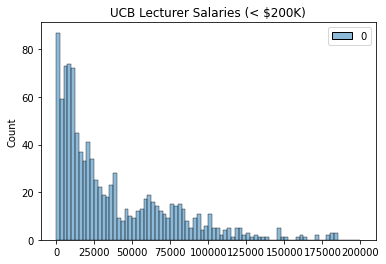

In [ ]:
sns.histplot(berkeley_lect_salaries_2020.groupby('Gross Pay'), bins=80, binrange=[0, 200000]).set_title('UCB Lecturer Salaries (< $200K)')

In [ ]:
sns.histplot(top_42_berkeley.groupby('Gross Pay'), bins=80, binrange=[0, 200000]).set_title('Top 42% of UCB Lecturer Salaries (< $200K)')

NameError: name 'top_42_berkeley' is not defined

In [ ]:
salaries_2020.groupby('Title')['Title'].count().reset_index(name='count').sort_values(['count']).to_csv('uc_title_counts.csv')

In [ ]:
lect_salaries_2020[['Location', 'Title', 'Gross Pay']].groupby('Location').agg('Gross Pay').describe()

,count,mean,std,min,25%,50%,75%,max
Location,,,,,,,,
Berkeley,1305.0,33297.744061,43389.774277,8.0,5438.00,15432.0,51030.00,476036.0
Davis,600.0,42269.790000,42946.212056,150.0,9390.25,24888.0,68112.75,418733.0
Irvine,583.0,30565.933105,33342.302437,200.0,6202.00,15196.0,52263.00,239352.0
Los Angeles,1376.0,33022.470203,39487.555107,100.0,7087.00,15838.5,46673.00,427660.0
Merced,179.0,53670.256983,25177.094679,500.0,32889.00,61440.0,70236.00,115680.0
Riverside,321.0,35602.943925,34258.481842,100.0,6640.00,19992.0,64782.00,147258.0
San Diego,461.0,45226.741866,43268.036758,75.0,10844.00,32372.0,65674.00,213393.0
San Francisco,3.0,11294.333333,19000.248586,150.0,325.00,500.0,16866.50,33233.0
Santa Barbara,369.0,46251.940379,40411.400707,100.0,8395.00,34953.0,72715.00,168997.0



## Misc Notes

`LECT-` is a little too specific. `LECT` is much too general. 

**TO INVESTIGATE / FIX:** 
This are U18 covered titles not included in the current analysis.
LECT IN SUMMER SESSION, CHILD DEV DEMO LECT, LECTURER, TEACHER-SPEC PROG

All titles with just `LECT`:

```
['LECT IN SUMMER SESSION', 'LECT-AY-CONTINUING', 'LECT-AY-1/9',
       'LECT-MISCELLANEOUS/PART TIME', 'ELECTED OFCR STDT GOVT',
       'LECT-AY', 'LECT PSOE-AY-B/E/E', 'LECT-AY-1/10',
       'LECT-AY-1/10-CONTINUING', 'LECT-FY', 'ELECTR TCHN PRN', 'ELECTRN',
       'SR LECT SOE-AY', 'ELECTR TCHN SR', 'HIGH VOLT ELECTRN',
       'LECT SOE-AY', 'LECT-FY-CONTINUING', 'LECT-AY-1/9-CONTINUING',
       'LECT PSOE-AY', 'SR LECT SOE-AY-B/E/E',
       'ELECTROCARDIOGRAPH TCHN SR', 'CHILD DEV DEMO LECT',
       'LECT SOE-AY-B/E/E', 'SR LECT SOE-AY-LAW', 'SR LECT-AY-CONTINUING',
       'ELECTRN LD', 'ELECTR TCHN', 'LECT PSOE-AY-1/9', 'REGENTS" LECT',
       'ELECTRN SPEC', 'LECT SOE-FY', 'LECTURER', 'LECT SOE-HCOMP',
       'ELECTRN AST SUPV', 'ELECTR TCHN SR SUPV', 'ARTS AND LECTURES MGR',
       'ELECTRN SUPV', 'MED CTR ELECTR TCHN SR', 'ELECTRN 2',
       'ACT LECT PSOE-AY', 'SR LECT SOE-AY-1/9', 'ELECTRN OPR 3',
       'SR LECT SOE-FY', 'HIGH VOLT ELECTRN LD',
       'SR LECT-AY-1/9-CONTINUING', 'MED CTR ELECTR TCHN PRN',
       'ELECTRN WORKER LD', 'MED CTR ELECTR TCHN',
       'CHILD DEV DEMO LECT-CONTINUING', 'ARTS AND LECTURES SUPV',
       'ELECTROCARDIOGRAPH TCHN', 'LECT PSOE-AY-LAW',
       'ACT LECT PSOE-AY-B/E/E', 'ELECTRN APPR', 'SR LECT-AY',
       'LECT SOE-AY-1/9', 'MED CTR ELECTR TCHN TRAINEE',
       'INTELLECTUAL PROPERTY OFCR 4', 'INTELLECTUAL PROPERTY OFCR 3',
       'ELECTROCARDIOGRAPH TCHN PD']
```

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4848061e-35b7-4752-bb33-0d4be542a4b2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>